<a href="https://colab.research.google.com/github/Jamnic98/blue-cheese-classifier/blob/main/blue_cheese_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np

# mount the google drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
root_dir = '/content/drive/MyDrive/'
class_names = ['blueCheese', 'notBlueCheese']
all_cheese_image_dirs = {class_names[0]: [], class_names[1]: []}

# create train, test and validation folders for each class of cheese
for class_name in class_names:
  train_URI = root_dir +'data/train/' + class_name
  if not os.path.isdir(train_URI):
    os.makedirs(train_URI)
  
  test_URI = root_dir +'data/test/' + class_name
  if not os.path.isdir(test_URI):
    os.makedirs(test_URI)
  
  val_URI = root_dir +'data/val/' + class_name
  if not os.path.isdir(val_URI):
    os.makedirs(val_URI)

  # compile a list of URIs for every cheese image
  cheeses = os.listdir(root_dir + class_name)
  for cheese_name in cheeses:
    cheese_dir = root_dir + class_name + '/' + cheese_name

    all_cheese_image_dirs[class_name].extend(
      [cheese_dir + '/'+ name for name in os.listdir(cheese_dir)]
      )  

In [3]:
import shutil

val_ratio = 0.2
test_ratio = 0.2

for class_name in class_names:
  cheese_image_dirs = all_cheese_image_dirs[class_name]

  # shuffle image URIs
  np.random.shuffle(cheese_image_dirs)

  train_FileNames, val_FileNames, test_FileNames = np.split(
    np.array(cheese_image_dirs),
    [int(len(cheese_image_dirs)* (1 - (val_ratio + test_ratio))), 
    int(len(cheese_image_dirs)* (1 - test_ratio))]
  )

  print('In folder :', class_name)
  print('Total images: ', len(cheese_image_dirs))
  print('Training: ', len(train_FileNames))
  print('Validation: ', len(val_FileNames))
  print('Testing: ', len(test_FileNames))
  print('\n')

  # # Copy-pasting images
  # for train_FileName in train_FileNames.tolist():
  #   shutil.copy(train_FileName, root_dir +'data/train/' + class_name)

  # for val_FileName in val_FileNames.tolist():
  #   shutil.copy(val_FileName, root_dir +'data/val/' + class_name)

  # for test_FileName in test_FileNames.tolist():
  #   shutil.copy(test_FileName, root_dir +'data/test/' + class_name)

In folder : blueCheese
Total images:  1896
Training:  1137
Validation:  379
Testing:  380


In folder : notBlueCheese
Total images:  1848
Training:  1108
Validation:  370
Testing:  370




In [4]:
# use ImageDataGenerator to preprocess the data
from keras.preprocessing.image import ImageDataGenerator

augmented_images_dir=root_dir + 'augmented_images/'
if not os.path.isdir(augmented_images_dir):
  os.mkdir(augmented_images_dir)

# augment the data that we have
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   rotation_range=30,
                                   horizontal_flip=True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

# prepare training data
augmented_train_images_dir = augmented_images_dir + 'train'
if not os.path.isdir(augmented_train_images_dir):
  os.mkdir(augmented_train_images_dir)
training_data = train_datagen.flow_from_directory('data/train',
                                                  # save_to_dir=augmented_train_images_dir,
                                                  target_size=(256, 256),
                                                  batch_size=32,
                                                  class_mode='categorical'
                                                  )

# prepare test data
augmented_test_images_dir = augmented_images_dir + 'test'
if not os.path.isdir(augmented_test_images_dir):
  os.mkdir(augmented_test_images_dir)
test_data = test_datagen.flow_from_directory('data/test',
                                              # save_to_dir=augmented_test_images_dir,
                                              target_size = (256, 256),
                                              batch_size = 32,
                                              class_mode = 'categorical'
                                              )

# prepare validation data
augmented_val_images_dir = augmented_images_dir + 'val'
if not os.path.isdir(augmented_val_images_dir):
  os.mkdir(augmented_val_images_dir)
validation_data = test_datagen.flow_from_directory('data/val',
                                                    # save_to_dir=augmented_val_images_dir,
                                                    target_size = (256, 256),
                                                    batch_size = 32,
                                                    class_mode = 'categorical'
                                                    )

Found 2994 images belonging to 2 classes.
Found 188 images belonging to 2 classes.
Found 562 images belonging to 2 classes.


In [5]:
### Build the model
# Importing the Keras libraries and packages for building
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
# make 32 feature detectors with a size of 3x3
# choose the input-image's format to be 256x256 with 3 channels
classifier.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation="relu"))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(activation="relu", units=128))
classifier.add(Dense(activation="softmax", units=2))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### **Change code below this message**

In [8]:
from keras.callbacks import EarlyStopping

history = classifier.fit(training_data,
               #steps_per_epoch = (10),
               epochs=100,
               validation_data=validation_data,
               validation_steps=10,
               callbacks=[EarlyStopping(monitor='loss', patience=5)])

Epoch 1/100
 3/94 [..............................] - ETA: 8:49 - loss: 9.6051 - accuracy: 0.4462

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


73/94 [======================>.......] - ETA: 4:07 - loss: 2.7786 - accuracy: 0.5209

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19 bytes but only got 18. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag)


94/94 [==============================] - 1277s 13s/step - loss: 2.4038 - accuracy: 0.5354 - val_loss: 0.6107 - val_accuracy: 0.7125
Epoch 2/100
94/94 [==============================] - 118s 1s/step - loss: 0.6125 - accuracy: 0.6800 - val_loss: 0.5960 - val_accuracy: 0.7063
Epoch 3/100
94/94 [==============================] - 91s 966ms/step - loss: 0.5986 - accuracy: 0.7019 - val_loss: 0.5388 - val_accuracy: 0.6875
Epoch 4/100
94/94 [==============================] - 82s 879ms/step - loss: 0.5720 - accuracy: 0.6993 - val_loss: 0.6071 - val_accuracy: 0.6875
Epoch 5/100
94/94 [==============================] - 78s 833ms/step - loss: 0.5895 - accuracy: 0.6770 - val_loss: 0.5800 - val_accuracy: 0.7063
Epoch 6/100
94/94 [==============================] - 77s 822ms/step - loss: 0.5859 - accuracy: 0.6852 - val_loss: 0.5256 - val_accuracy: 0.7188
Epoch 7/100
94/94 [==============================] - 75s 796ms/step - loss: 0.5736 - accuracy: 0.7025 - val_loss: 0.5770 - val_accuracy: 0.6969
Epoch 

In [9]:
generator= train_datagen.flow_from_directory("data/train", batch_size=32)
label_map = (generator.class_indices)
label_map

Found 2994 images belonging to 2 classes.


{'blueCheese': 0, 'notBlueCheese': 1}

In [10]:
# from tensorflow import keras
# classifier = keras.models.load_model(root_dir + 'my_model')

In [18]:
from contextlib import redirect_stdout

model_name = 'my_model4'
model_dir = root_dir + model_name

if not os.path.isdir(model_dir):
  os.mkdir(model_dir)

with open(f'{model_dir}/{model_name}.txt', 'w') as file:
    with redirect_stdout(file):
        classifier.summary()

test_loss, test_acc = classifier.evaluate(test_data, verbose=2)
with open(f'{model_dir}/{model_name}.txt', 'a') as file:
  file.write(f'\nAccuracy: {test_acc}')

classifier.save(model_dir)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


6/6 - 2s - loss: 0.2557 - accuracy: 0.9096
INFO:tensorflow:Assets written to: /content/drive/MyDrive/my_model4/assets


In [11]:
## make predictions
from keras.preprocessing import image
# we have to resize our image if we haven't already
test_image = image.load_img('data/test/notBlueCheese/comte103.jpg', target_size = (256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
print('Predicted class: ', int(result[0][0]))
print(result)

predictions = classifier.predict(training_data)
print(predictions)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = training_data.classes
class_labels = list(training_data.class_indices.keys())


import sklearn.metrics as metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
confusion_matrix

Predicted class:  0
[[0. 1.]]


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19 bytes but only got 18. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[[9.9997568e-01 2.4289351e-05]
 [1.0000000e+00 8.9639868e-10]
 [2.8463799e-01 7.1536201e-01]
 ...
 [8.6870670e-01 1.3129330e-01]
 [1.2800494e-01 8.7199503e-01]
 [9.9977082e-01 2.2921806e-04]]
               precision    recall  f1-score   support

   blueCheese       0.51      0.50      0.50      1516
notBlueCheese       0.49      0.50      0.49      1478

     accuracy                           0.50      2994
    macro avg       0.50      0.50      0.50      2994
 weighted avg       0.50      0.50      0.50      2994



array([[759, 757],
       [743, 735]])

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


6/6 - 59s - loss: 0.2557 - accuracy: 0.9096
Accuracy:  0.9095744490623474


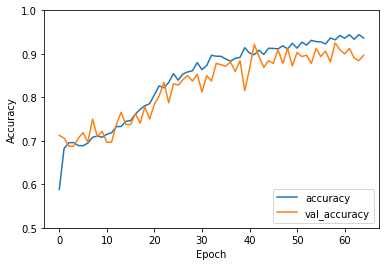

In [14]:
import matplotlib.pyplot as plt
test_loss, test_acc = classifier.evaluate(test_data, verbose=2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

print('Accuracy: ', test_acc)